In [ ]:
from collections import defaultdict
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import keras_core
from keras.models import load_model
from collections import Counter

2024-01-03 22:34:04.919003: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


# Estrazione labels

In [ ]:
df = pd.read_csv("/Users/Vitto_1/Desktop/Visual_matlab/progetto_esame/train_info_dirty.csv", sep=',', header=None)

In [ ]:
# Ordina il DataFrame in base alla colonna del nome delle immagini
df_ordinato = df.sort_values(by=0)
# Crea una lista contenente le classi per ogni immagine
y=list(df_ordinato[1])

# Estrazione immagini

In [ ]:
# Crea un dataset di immagini dalla directory specificata
data = tf.keras.utils.image_dataset_from_directory(
    "/Users/Vitto_1/Desktop/Visual_matlab/progetto_esame/train_set",
    labels=y,  # Etichette delle immagini
    label_mode="categorical",  # Specifica la modalità di encoding delle etichette
    color_mode="rgb",  # Formato RGB per le immagini
    batch_size=None,  # Dimensioni del batch
    image_size=(64, 64),  # Imposta le dimensioni delle immagini a 64x64 pixel
    shuffle=False,  # Non mescola le immagini all'interno del dataset
    seed=777,  # Seme per la riproducibilità
    validation_split=None,  # Non specifica una suddivisione per il validation
    subset=None  # Non specifica un sottoinsieme del dataset
)

Found 118475 files belonging to 251 classes.


Visualizzazione prima immagine

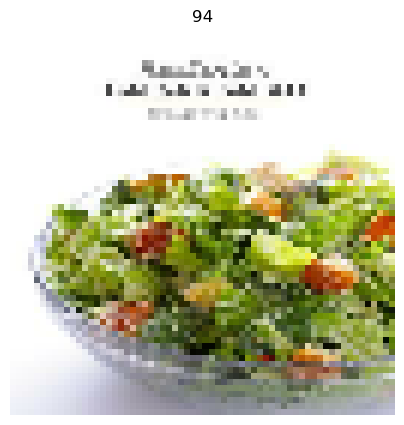

In [ ]:
plt.figure(figsize=(5, 5))
for images, labels in data.take(1):
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(tf.where(labels == 1)[:, 0].numpy()[0])
    plt.axis("off")

# Define hyperparameters

In [ ]:
target_size = 64  # Ridimensiona le immagini in input a 64x64 pixel.
representation_dim = 512  # Dimensioni del vettore delle caratteristiche della rappresentazione.
projection_units = 128  # Unità del "projection head" del learner di rappresentazione.
num_clusters = 251  # Numero di cluster.
k_neighbours = 5  # Numero di vicini da considerare durante l'apprendimento del clustering.
tune_encoder_during_clustering = False  # Congela l'encoder durante l'apprendimento del clustering.

In [ ]:
image_matrices=[]
y_matrices = []
for images, labels in data:
    image_matrices.append(images.numpy())
    y_matrices.append(tf.where(labels == 1)[:, 0].numpy()[0])

In [ ]:
# Crea un indice di mescolamento
shuffle_index = np.random.permutation(len(image_matrices))
# Applica la mescolanza agli array
image_matrices = [image_matrices[i] for i in shuffle_index]
y_matrices = [y_matrices[i] for i in shuffle_index]

In [ ]:
image_matrices = np.array(image_matrices)

# Implement data preprocessing

In [ ]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size),
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(image_matrices)

# Data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.15, fill_mode="nearest"),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        ),
    ]
)

# Self-supervised representation learning

### Implement the vision encoder

In [ ]:
def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
            keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg"
            ),
            layers.Dense(representation_dim),
        ]
    )
    return encoder

### Implement the unsupervised contrastive loss

In [ ]:
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = keras_core.ops.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = keras.utils.normalize(feature_vectors)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = keras_core.ops.max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = keras_core.ops.tile(
            tf.eye(batch_size), [num_augmentations, num_augmentations]
        )
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = keras_core.ops.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = keras_core.ops.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

### Train the model

In [ ]:
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(encoder, projection_units, num_augmentations=2, temperature=0.1)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.001, decay_steps=500, alpha=0.1)
# Compile the model.
representation_learner.compile(optimizer=keras.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),jit_compile=False,)
# Fit the model.
history = representation_learner.fit(x=image_matrices,batch_size=512,epochs=100)

Epoch 1/100
232/232 [==============================] - 6361s 27s/step - loss: 60.3778
Epoch 2/100
232/232 [==============================] - 6231s 27s/step - loss: 17.0323
Epoch 3/100
232/232 [==============================] - 6264s 27s/step - loss: 13.1561
Epoch 4/100
232/232 [==============================] - 6224s 27s/step - loss: 13.0931
Epoch 5/100
206/232 [=========================>....] - ETA: 11:33 - loss: 13.0219

Salvataggio modello

In [ ]:
representation_learner.save_weights("representation_learning.h5")

Plot training loss

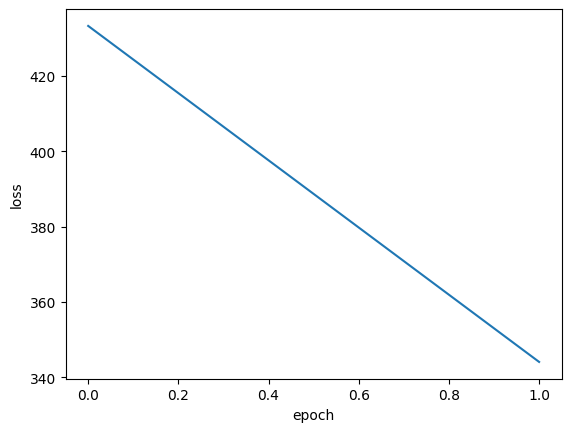

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Compute the nearest neighbors

### Generate the embeddings for the images

In [ ]:
batch_size = 500
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(image_matrices, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
feature_vectors = keras.utils.normalize(feature_vectors)

10/10 [==============================] - 3s 275ms/step


### Find the k nearest neighbours for each embedding

In [ ]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = keras_core.ops.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

100%|██████████| 10/10 [00:00<00:00, 103.16it/s]


# Semantic clustering with nearest neighbours

### Implement clustering consistency loss

In [ ]:
class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = keras_core.ops.ones_like(similarity)
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return keras_core.ops.mean(loss)

### Implement the clusters entropy loss

In [ ]:
class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super().__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = keras_core.ops.cast(
            keras_core.ops.shape(cluster_probabilities)[-1], "float32"
        )
        target = keras_core.ops.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = keras_core.ops.mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = keras_core.ops.clip(cluster_probabilities, 1e-8, 1.0)
        # Compute the entropy over the clusters.
        entropy = -keras_core.ops.sum(
            cluster_probabilities * keras_core.ops.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss

### Implement clustering model

In [ ]:
input_shape = (64, 64, 3)

In [ ]:
def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

### Implement clustering learner

In [ ]:
def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = keras_core.ops.reshape(neighbours, tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = keras_core.ops.reshape(
        neighbours_clustering,
        (-1, k_neighbours, keras_core.ops.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = keras_core.ops.einsum(
        "bij,bkj->bik",
        keras_core.ops.expand_dims(anchor_clustering, axis=1),
        neighbours_clustering,
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(
        lambda x: keras_core.ops.squeeze(x, axis=1), name="similarity"
    )(similarity)
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model

### Train model

In [ ]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)
# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
# Create the model inputs and labels.
inputs = {"anchors": image_matrices, "neighbours": tf.gather(image_matrices, neighbours)}
labels = np.ones(shape=(image_matrices.shape[0]))
# Compile the model.
clustering_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
    jit_compile=False,
)
# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=512, epochs=100)

Epoch 1/2


1/1 [==============================] - 25s 25s/step - loss: 0.7087 - similarity_loss: 0.6911 - clustering_loss: 0.0176
Epoch 2/2
1/1 [==============================] - 5s 5s/step - loss: 0.7051 - similarity_loss: 0.6911 - clustering_loss: 0.0140


Salvataggio modello

In [ ]:
clustering_model.save("Cluster_model.h5")

Plot training loss

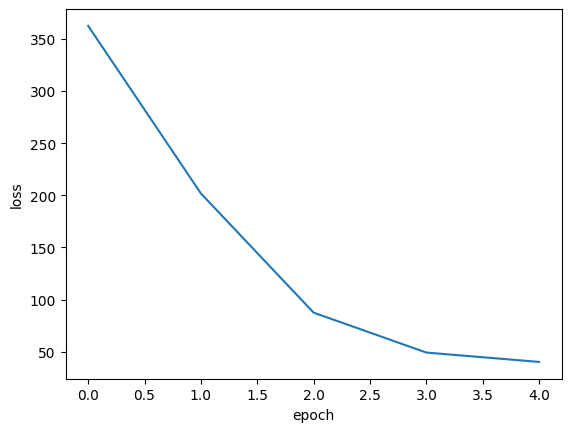

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Cluster analysis

### Assign images to clusters

In [ ]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(image_matrices, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = keras_core.ops.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = keras_core.ops.max(clustering_probs, axis=-1).numpy()

2/2 [==============================] - 3s 300ms/step


Calcolo dimensioni dei cluster

In [ ]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

non_empty_clusters = defaultdict(list)
for c in clusters.keys():
    if clusters[c]:
        non_empty_clusters[c] = clusters[c]

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

cluster 0 : 2
cluster 1 : 0
cluster 2 : 1
cluster 3 : 0
cluster 4 : 0
cluster 5 : 2
cluster 6 : 82
cluster 7 : 10
cluster 8 : 0
cluster 9 : 0
cluster 10 : 3
cluster 11 : 0
cluster 12 : 0


# Rimozione immagini classificate male

In [ ]:
c = 0
diz = {}
for i in cluster_assignments:
    lab = y_matrices[c]
    if i not in diz:
        diz[i] = [[shuffle_index[c], lab]]
    else:
        diz[i].append([shuffle_index[c], lab])
    c += 1

In [ ]:
from collections import Counter

for cluster_id, cluster_values in diz.items():
    character_list = [value[1] for value in cluster_values]
    total_characters = len(character_list)

    # Conta tutti i caratteri
    character_counter = Counter(character_list)

    # Calcola la frequenza e converti la frequenza in percentuali
    occurrence_percentage = [(char, occ / total_characters * 100) for char, occ in character_counter.most_common()]

    print(f"Cluster {cluster_id} -", end=' ')

    # Stampa direttamente con il simbolo percentuale senza andare a capo
    printed_chars = 0
    for char, pct in occurrence_percentage:
        if pct > 10:
            if printed_chars > 0:
                print(" | ", end='')
            print(f"{char}: {pct:.2f}%", end='')
            printed_chars += 1

    # Vai a capo solo alla fine del cluster
    print()

Cluster 6 - 94: 86.59%
Cluster 7 - 94: 100.00%
Cluster 2 - 94: 100.00%
Cluster 10 - 94: 100.00%
Cluster 0 - 250: 50.00% | 94: 50.00%
Cluster 5 - 94: 100.00%


In [ ]:
# Trova i valori più comuni nella seconda posizione di tutte le liste
all_values = [val[1] for values in diz.values() for val in values]
counts = Counter(all_values)
most_common_value = counts.most_common(1)[0][0]

# Filtra il dizionario mantenendo solo le liste in cui il valore nella seconda posizione è il più comune
filtered_dict = {key: [val for val in values if val[1] != most_common_value] for key, values in diz.items()}

# Seleziona il primo valore per ogni chiave
first_values = [val[0] for values in filtered_dict.values() for val in values]

In [ ]:
li = [df_ordinato.iloc[val][0] for val in first_values]
li

['train_000003.jpg',
 'train_000015.jpg',
 'train_000018.jpg',
 'train_000057.jpg',
 'train_000079.jpg',
 'train_000081.jpg',
 'train_000033.jpg',
 'train_000008.jpg',
 'train_000073.jpg',
 'train_000044.jpg',
 'train_000049.jpg',
 'train_000005.jpg']

# Salvataggio Dizionario

In [ ]:
import pickle
with open("/Users/Vitto_1/Desktop/Visual_matlab/progetto_esame/diz.pkl", 'wb') as f:
    pickle.dump(diz, f)

In [ ]:
with open("/Users/Vitto_1/Desktop/Visual_matlab/progetto_esame/lista.pkl", 'wb') as f:
    pickle.dump(li, f)

**Reference**

- SIC: [semantic_image_clustering](https://keras.io/examples/vision/semantic_image_clustering/)